In [1]:
## import required packages
import numpy as np
import pandas as pd

## import the training data set, including bidder_id and type of the agent ('outcome')
train_data = pd.read_csv("train.csv")
## bidding history, including both training ant test sets
bid_history = pd.read_csv("bids.csv")

In [2]:
def ConvertTime(history):
    """
    Converting encrypted time stamps into seconds and create the day, hour, minute, second stamps for each bid
    @param: history: bidding history of all bidders
    @return: None    
    """
    SECONDS_PER_MINUTE = 60
    SECONDS_PER_HOUR = SECONDS_PER_MINUTE * 60
    SECONDS_PER_DAY  = SECONDS_PER_HOUR * 24
    # convert time to seconds
    history['time'] /= 52631580
    # time start with 0 second
    history['time'] -= min(history['time'])
    history['day'] = (history['time'] / SECONDS_PER_DAY).astype(int)
    history['hour'] = ((history['time'] % SECONDS_PER_DAY) / SECONDS_PER_HOUR).astype(int)
    history['minute'] = (((history['time'] % SECONDS_PER_DAY) % SECONDS_PER_HOUR) / SECONDS_PER_MINUTE).astype(int)
    history['second'] = (((history['time'] % SECONDS_PER_DAY) % SECONDS_PER_HOUR) % SECONDS_PER_MINUTE)

In [3]:
def entropy(arr):
    """
    Calculating the entropy of an array storing counts of a categorical data set
    @param arr: an array of integer values
    @return: the entropy of arr
    """
    pk = arr / sum(arr)
    return -sum(pk * np.log(pk))

In [4]:
ConvertTime(bid_history)

In [5]:
def GenerateFeature(bidders, history, training):
    """
    Read the data set and generate the corresponding features
    @param bidders: dataframe including fields of 'bidder_id'. If it is a training set, it also includes the label of the bidder
    @param history: bidding history of all bidders
    @param training: Boolean value. True if data is a training set; False if data is a test set
    @return df: data frame with features
    """
    if training:
        df = bidders.loc[:,['bidder_id','outcome']]
    else:
        df = bidders.loc[:,['bidder_id']]
    
    # total number of bids performed by each bidder
    num_bids = history['bidder_id'].value_counts().to_frame()
    num_bids.columns = ['num_bids']
    df = bidders.loc[:,['bidder_id','outcome']].join(num_bids, on = 'bidder_id', lsuffix='_l')
    print "Get num_bids"
    
    
    history = history.sort_values(by=['bidder_id', 'time', 'auction'])
    history['time_diff_same_auction'] = history.groupby(['bidder_id','auction'])['time'].diff()
    min_time_diff_same_auction = history.groupby(['bidder_id'])['time_diff_same_auction'].median()
    min_time_diff_same_auction = pd.DataFrame({'bidder_id': min_time_diff_same_auction.index, 'min_time_diff_same_auction': min_time_diff_same_auction.values})
    df = pd.merge(df, min_time_diff_same_auction, on = 'bidder_id', how = 'left')
    print "Get min_time_diff_same_auction"
    
    # get the max number of bids by each bidder in 20 minute    
    TIME_SEGMENT = 20
    history['segement_id_20min'] = (history['minute'] / TIME_SEGMENT).astype(int)
    numbids_per_auction_20min = history.groupby(['bidder_id','auction', 'segement_id_20min']).apply(len)
    max_numbids_per_auction_20min = numbids_per_auction_20min.max(level=[0])
    max_numbids_per_auction_20min = pd.DataFrame({'bidder_id': max_numbids_per_auction_20min.index, 'max_numbids_per_auction_20min': max_numbids_per_auction_20min.values})
    df = pd.merge(df, max_numbids_per_auction_20min, on = 'bidder_id', how = 'left')
    print "Get max_numbids_per_auction_20min"
     
    
    # get the number of auctions participated by a bidder
    num_auction = history.groupby('bidder_id')['auction'].unique().apply(len)
    num_auction = pd.DataFrame({'bidder_id': num_auction.index, 'num_auction': num_auction.values})
    df = pd.merge(df,num_auction, on = 'bidder_id', how = 'left')
    print "Get num_auction"
    

    # get the number of urls used by a bidder
    num_url = history.groupby('bidder_id')['url'].unique().apply(len)
    num_url = pd.DataFrame({'bidder_id': num_url.index, 'num_url': num_url.values})
    df = pd.merge(df,num_url, on = 'bidder_id', how = 'left')
    print "Get num_url"
    
    
    # get the number of countries that a bidder is located
    num_country = history.groupby('bidder_id')['country'].unique().apply(len)
    num_country = pd.DataFrame({'bidder_id': num_country.index, 'num_country': num_country.values})
    df = pd.merge(df,num_country, on = 'bidder_id', how = 'left')
    print "Get num_country"
    
    # get the number of devices used by a bidder
    num_device = history.groupby('bidder_id')['device'].unique().apply(len)
    num_device = pd.DataFrame({'bidder_id': num_device.index, 'num_device': num_device.values})
    df = pd.merge(df,num_device, on = 'bidder_id', how = 'left')
    print "Get num_device"
    
    # get the number of ip addresses used by a bidder
    num_ip = history.groupby('bidder_id')['ip'].unique().apply(len)
    num_ip = pd.DataFrame({'bidder_id': num_ip.index, 'num_ip': num_ip.values})
    df = pd.merge(df,num_ip, on = 'bidder_id', how = 'left')
    print "Get num_ip"
    
    # get ip entropy
    grouped_ip_count = history.groupby(['bidder_id','ip']).apply(len)
    ip_entropy = grouped_ip_count.groupby(level = 0).apply(entropy)
    ip_entropy = pd.DataFrame({'bidder_id': ip_entropy.index, 'ip_entropy': ip_entropy.values})
    df = pd.merge(df,ip_entropy, on = 'bidder_id', how = 'left')
    print("Get ip_entropy")
    
    # get url entropy
    grouped_url_count = history.groupby(['bidder_id','url']).apply(len)
    url_entropy = grouped_url_count.groupby(level = 0).apply(entropy)
    url_entropy = pd.DataFrame({'bidder_id': url_entropy.index, 'url_entropy': url_entropy.values})
    df = pd.merge(df,url_entropy, on = 'bidder_id', how = 'left')
    print("Get url_entropy")
    
    # get device entropy
    grouped_device_count = history.groupby(['bidder_id','device']).apply(len)
    device_entropy = grouped_device_count.groupby(level = 0).apply(entropy)
    device_entropy = pd.DataFrame({'bidder_id': device_entropy.index, 'device_entropy': device_entropy.values})
    df = pd.merge(df,device_entropy, on = 'bidder_id', how = 'left')
    print("Get device_entropy")
    
    # get average hour entropy (average over countries)
    hour_count_per_country = bid_history.groupby(['bidder_id','country','hour']).apply(len)
    hour_entropy_per_country = hour_count_per_country.groupby(level = [0,1]).apply(entropy)
    hour_entropy = hour_entropy_per_country.groupby(level = 0).apply(np.mean)
    hour_entropy = pd.DataFrame({'bidder_id': hour_entropy.index, 'hour_entropy': hour_entropy.values})
    df = pd.merge(df,hour_entropy, on = 'bidder_id', how = 'left')
    print("Get hour_entropy")
    
    # get the probability that a bidder wins an auction
    winner_id = history.loc[bid_history.groupby('auction')['time'].idxmax()].bidder_id
    win_counts = pd.DataFrame({'bidder_id': winner_id.value_counts().index, 'win_counts': winner_id.value_counts().values})
    df = pd.merge(df,win_counts, on = 'bidder_id', how = 'left')
    df.win_counts = df.win_counts.fillna(0)
    df['win_prob'] = df['win_counts'] / df['num_auction']
    df = df.drop('win_counts', 1)
    print("Get win_prob")
    
    # get the average number of urls used by a device
    df['avg_num_url_per_device'] = df.num_url / df.num_device
    df['avg_num_url_per_device'] = df['avg_num_url_per_device'].fillna(0)
    
    #df['avg_num_bids_per_auction'] = df.num_bids / df.num_auction
    #df['avg_num_bids_per_auction'] = df['avg_num_bids_per_auction'].fillna(0)
    
    
    # For users submitting less than 1 bids, setting its min_time_diff_same_auction to a large number
    df.min_time_diff_same_auction = df.min_time_diff_same_auction.fillna(df.min_time_diff_same_auction.max()*100)

    df = df.fillna(0)
    return df




    

In [6]:
df = GenerateFeature(train_data, bid_history, training = True)

Get num_bids
Get min_time_diff_same_auction
Get max_numbids_per_auction_20min
Get num_auction
Get num_url
Get num_country
Get num_device
Get num_ip
Get ip_entropy
Get url_entropy
Get device_entropy
Get hour_entropy
Get win_prob


In [7]:
df[(df['outcome'] == 1)].describe()

,outcome,num_bids,min_time_diff_same_auction,max_numbids_per_auction_20min,num_auction,num_url,num_country,num_device,num_ip,ip_entropy,url_entropy,device_entropy,hour_entropy,win_prob,avg_num_url_per_device
count,103.0,103.000000,1.030000e+02,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,1.0,4004.038835,6.640188e+06,340.912621,145.038835,544.582524,26.475728,163.611650,2387.796117,4.599000,2.638433,2.758170,1.075393,0.043726,7.611989
std,0.0,16370.097403,2.953348e+07,2082.187157,195.103186,1163.909786,31.158622,222.811854,11269.674137,2.687466,2.347788,1.765078,0.601961,0.113448,29.596003
min,1.0,1.000000,8.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.008065
25%,1.0,288.000000,1.000000e+02,24.000000,23.000000,4.500000,3.000000,4.500000,34.000000,2.155149,0.197655,1.101417,0.679991,0.000000,0.607692
50%,1.0,716.000000,6.090000e+02,55.000000,74.000000,88.000000,13.000000,78.000000,290.000000,5.137297,2.345790,3.270671,1.052194,0.009901,2.000000
75%,1.0,2332.500000,1.405750e+03,137.000000,170.500000,591.000000,41.500000,219.000000,1089.000000,6.645241,5.033401,4.400002,1.412230,0.039779,4.195547
max,1.0,161935.000000,1.367542e+08,21104.000000,1018.000000,8551.000000,179.000000,1144.000000,111918.000000,11.254165,6.658489,5.162447,3.078652,1.000000,248.666667


In [8]:
df[(df['outcome'] == 0)].describe()

,outcome,num_bids,min_time_diff_same_auction,max_numbids_per_auction_20min,num_auction,num_url,num_country,num_device,num_ip,ip_entropy,url_entropy,device_entropy,hour_entropy,win_prob,avg_num_url_per_device
count,1910.0,1910.000000,1.910000e+03,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000
mean,0.0,1392.046073,4.234820e+07,70.293717,57.189005,330.097906,12.484293,72.824607,572.430890,2.683290,1.560550,2.018459,0.700911,0.011359,1.234794
std,0.0,14487.265477,6.320997e+07,446.081612,142.021381,2714.979379,22.748897,183.376886,4109.721882,2.288652,1.624869,1.650189,0.628644,0.047504,2.094095
min,0.0,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000
25%,0.0,3.000000,3.112000e+03,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,0.693147,-0.000000,0.636514,0.126346,0.000000,0.500000
50%,0.0,14.000000,2.835100e+04,2.000000,9.000000,4.000000,3.000000,7.000000,10.000000,2.271869,1.070967,1.816563,0.654323,0.000000,1.000000
75%,0.0,136.000000,1.367542e+08,11.000000,40.000000,33.000000,10.000000,50.000000,86.750000,4.246183,2.487472,3.433878,1.030862,0.000000,1.000000
max,0.0,515033.000000,1.367542e+08,8543.000000,1623.000000,81376.000000,164.000000,2618.000000,109159.000000,10.106916,8.942253,5.924976,3.054211,0.916667,39.143660


In [9]:
# splitting training data into features and labels
X_all = df.loc[:,'num_bids':]
y_all = df['outcome']
num_features = X_all.shape[1]


In [10]:
from sklearn.grid_search import GridSearchCV 
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.ensemble import RandomForestRegressor


def PredictRandomForest(X_all, seed):
    """
    Contructing a random forest regressor
    @param X_all: input feature set
    @param seed: seed used to initialize the random forest
    @return clf: random forest regressor
    """
    
    num_features = X_all.shape[1]
    
    # Create the parameters list you wish to tune
    parameters = {'max_features': range(1,num_features+1), 'max_depth':range(1,10)}

    # Initialize the classifier
    clf = RandomForestRegressor(n_estimators= 20, random_state = seed)

    # Make an f1 scoring function using 'make_scorer' 
    roc_auc_scorer = make_scorer(roc_auc_score)

    # Perform grid search on the classifier using the f1_scorer as the scoring method
    grid_obj = GridSearchCV(clf, parameters, scoring = roc_auc_scorer, cv = 5)

    # Fit the grid search object to the training data and find the optimal parameters
    grid_obj = grid_obj.fit(X_all, y_all)

    # Get the estimator
    clf = grid_obj.best_estimator_
    
    print clf.feature_importances_
    
    return clf

seed = [0, 10, 20, 30, 40, 50, 60, 70, 80];
clf_rf_list = [0] * len(seed)
i = 0
# get different random forest models with different seeds
for s in seed:
    clf_rf_list[i] = PredictRandomForest(X_all, s)
    i += 1


C:\Users\skywoods\Anaconda3\envs\python2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\skywoods\Anaconda3\envs\python2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[ 0.1546637   0.1120962   0.08933866  0.0255224   0.04581425  0.0274365
  0.10360837  0.02773199  0.08573954  0.06173953  0.1029805   0.05961879
  0.03644681  0.06726277]
[ 0.11042255  0.07965681  0.06682078  0.06891363  0.0670881   0.06780702
  0.08405601  0.06828101  0.06270001  0.09397616  0.06336983  0.04812439
  0.04541008  0.07337363]
[ 0.10629656  0.09509207  0.17566494  0.04214633  0.05139641  0.05351199
  0.06052771  0.05972391  0.06479849  0.07870702  0.080636    0.04046104
  0.02818626  0.06285129]
[ 0.14512956  0.1190556   0.11377704  0.02202133  0.05052144  0.02338024
  0.05100626  0.06052135  0.06150203  0.04598694  0.13529446  0.04582418
  0.03387232  0.09210724]
[ 0.18118056  0.08057987  0.17180662  0.03127159  0.01991348  0.0192999
  0.08197623  0.03530264  0.05053744  0.09787819  0.12926772  0.02759308
  0.00221188  0.07118081]
[ 0.11492261  0.10273552  0.16354571  0.05294226  0.03798444  0.02614224
  0.05138183  0.04683562  0.073797    0.06942915  0.10518245  0.05711

In [13]:
train_pred =[0] * X_all.shape[0]

for clf in clf_rf_list:
    train_pred += clf.predict(X_all) * 1.0 / len(clf_rf_list)
print "Tuned model has a training AUC score of {:.4f}.".format(roc_auc_score(y_all, train_pred))

Tuned model has a training AUC score of 0.9766.


In [14]:
# reading test data
test_data = pd.read_csv("test.csv")
# extracting features for the test data
df_test = GenerateFeature(test_data, bid_history, training = False)

Get num_bids
Get min_time_diff_same_auction
Get max_numbids_per_auction_20min
Get num_auction
Get num_url
Get num_country
Get num_device
Get num_ip
Get ip_entropy
Get url_entropy
Get device_entropy
Get hour_entropy
Get win_prob


In [15]:
# making final prediction for the test data set
X_test_all = df_test.loc[:,'num_bids':]
final_pred =[0] * X_test_all.shape[0]
# make the final prediction by averaging the prediction of each random forest
for clf in clf_rf_list:
    final_pred += clf.predict(X_test_all)

final_pred = final_pred / (len(clf_rf_list))


In [16]:
# converting the prediction into data frame and output file for submission
output_dataframe = pd.DataFrame({'bidder_id':df_test.bidder_id,'prediction':final_pred})
output_dataframe.to_csv('out.csv', index = False)

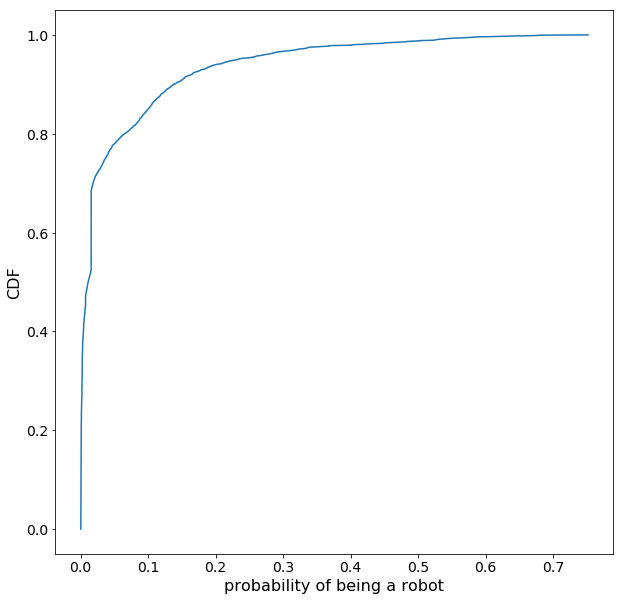

In [18]:
import matplotlib as plt
from pylab import *
# plot the CDF of the probability predicted using our model
sorted_data = np.sort(output_dataframe.prediction)
plt.figure(figsize=(10,10))
plt.plot(sorted_data,np.array(range(0,len(output_dataframe.prediction))) * 1.0 / len(output_dataframe.prediction) )
plt.xlabel('probability of being a robot', fontsize = 16)
plt.ylabel('CDF', fontsize = 16)
plt.tick_params(labelsize=14)
plt.show()


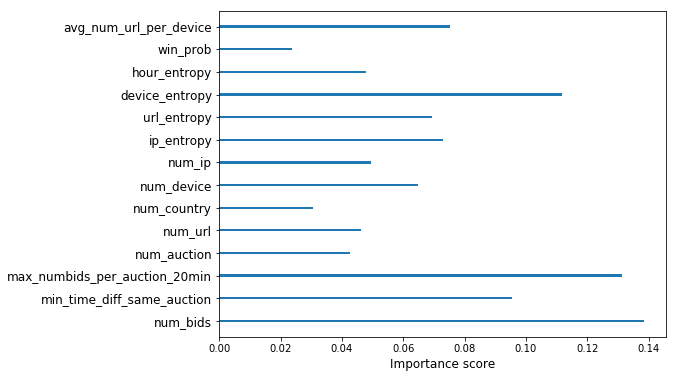

In [19]:
# plot importance scores of features in a bar figure
importance_score = [0.1386, 0.0955, 0.1313, 0.0427, 0.0462, 0.0306, 0.0647, 0.0495, 0.0730, 0.0695, 0.1118, 0.0479, 0.0237, 0.0751]
fig = plt.figure(figsize=(8,6))
pos = np.array(range(len(importance_score)))+.5
barh(pos,importance_score, align='center',height=0.1)
xlabel('Importance score',fontsize = 12)
yticks(pos, ('num_bids', 'min_time_diff_same_auction', 'max_numbids_per_auction_20min', 'num_auction', 'num_url','num_country','num_device','num_ip','ip_entropy','url_entropy','device_entropy','hour_entropy','win_prob','avg_num_url_per_device'),fontsize = 12)
show()